In [53]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import os
from pathlib import Path


In [ ]:
# Setting up the subfolder to store general data

project_root = Path.cwd().parent
data_path = project_root / "data"
data_path.mkdir(exist_ok=True)

In [ ]:
train = pd.read_csv(data_path / "all_train_df.csv")
val = pd.read_csv(data_path / "all_val_df.csv")
test = pd.read_csv(data_path / "all_test_df.csv")

pd.set_option('display.max_columns', None)

In [56]:
train

,Stock Type,Date,Close,High,Low,Open,Volume,Year,MonthLength,DayOfYear_sin,DayOfYear_cos,Month_sin,Month_cos,Day_sin,Day_cos,DayOfWeek_sin,DayOfWeek_cos,SMA_5,SMA_10,SMA_20,SMA_30,RSI_14,BB_High,BB_Low,BB_Middle,BB_Width,MACD,MACD_Signal,MACD_Diff,Price Range,Volatility_5,Volatility_10,Return_5,Price Change,Prev Close,Target,Close_lag1,Close_lag2,Close_lag3,Close_lag5,Return_5_lag1,Return_5_lag2,Return_5_lag3,Return_5_lag5,Volatility_5_lag1,Volatility_5_lag2,Volatility_5_lag3,Volatility_5_lag5,Volatility_10_lag1,Volatility_10_lag2,Volatility_10_lag3,Volatility_10_lag5,Price Change_lag1,Price Change_lag2,Price Change_lag3,Price Change_lag5,RSI_14_lag1,RSI_14_lag2,RSI_14_lag3,RSI_14_lag5,MACD_lag1,MACD_lag2,MACD_lag3,MACD_lag5,Weighted_Sentiment,Mean_Sentiment,Headline_Count,Sentiment_Label,Has_Sentiment,Stock_0,Stock_1,Stock_2,Stock_3,Stock_4
0,0,2010-01-04,2.156775,2.158797,2.150016,2.154375,20.017499,2010,31,6.880243e-02,0.997630,5.000000e-01,0.866025,7.247928e-01,0.688967,0.000000,1.000000,2.146006,2.124078,2.097433,2.098084,67.302451,2.163788,6.586420,2.097433,2.811901,0.140228,0.076727,0.063501,0.072985,0.061579,0.210486,0.023775,0.020714,2.143129,1,2.143129,2.146933,2.136277,2.136024,0.042702,0.056299,0.054835,0.087903,0.045012,0.130509,0.161521,0.168004,0.232614,0.234921,0.224730,0.163893,-0.085715,0.100357,-0.126072,0.196071,64.127890,65.773000,63.335150,65.468186,0.123072,0.111312,0.091374,0.041243,1.00,1.00,1.0,positive,1,1,0,0,0,0
1,0,2010-01-05,2.158302,2.163282,2.153629,2.159210,20.140544,2010,31,8.596480e-02,0.996298,5.000000e-01,0.866025,8.486443e-01,0.528964,0.781831,0.623490,2.148318,2.132136,2.102039,2.100107,67.650242,2.171580,6.593546,2.102039,2.856951,0.153125,0.092006,0.061119,0.080263,0.076559,0.187853,0.013090,-0.007857,2.156775,0,2.156775,2.143129,2.146933,2.146808,0.023775,0.042702,0.056299,0.082792,0.061579,0.045012,0.130509,0.187327,0.210486,0.232614,0.234921,0.207810,0.020714,-0.085715,0.100357,-0.003929,67.302451,64.127890,65.773000,67.764041,0.140228,0.123072,0.111312,0.073833,0.00,0.00,5.0,neutral,1,1,0,0,0,0
2,0,2010-01-08,2.148351,2.148434,2.136109,2.141326,19.919435,2010,31,1.372788e-01,0.990532,5.000000e-01,0.866025,9.987165e-01,-0.050649,-0.433884,-0.900969,2.150033,2.145948,2.114382,2.103497,62.178776,2.179504,6.727009,2.114382,2.791491,0.147113,0.119615,0.027498,0.099845,0.060130,0.061402,0.005932,0.060000,2.142500,0,2.142500,2.144134,2.158302,2.143129,-0.005008,0.008943,0.013090,0.042702,0.065356,0.059801,0.076559,0.045012,0.114981,0.153939,0.187853,0.232614,-0.041786,-0.121786,-0.007857,-0.085715,60.479170,61.190501,67.650242,64.127890,0.147867,0.151770,0.153125,0.123072,0.00,0.00,2.0,neutral,1,1,0,0,0,0
3,0,2010-01-11,2.140528,2.152592,2.133532,2.151762,19.951572,2010,31,1.882267e-01,0.982126,5.000000e-01,0.866025,7.907757e-01,-0.612106,0.000000,1.000000,2.146783,2.146395,2.117326,2.104356,58.556448,2.181526,6.757968,2.117326,2.777295,0.139518,0.123596,0.015922,0.150573,0.058869,0.056990,-0.018223,-0.096071,2.148351,0,2.148351,2.142500,2.144134,2.156775,0.005932,-0.005008,0.008943,0.023775,0.060130,0.065356,0.059801,0.061579,0.061402,0.114981,0.153939,0.210486,0.060000,-0.041786,-0.121786,0.020714,62.178776,60.479170,61.190501,67.302451,0.147113,0.147867,0.151770,0.140228,0.00,0.00,2.0,neutral,1,1,0,0,0,0
4,0,2010-01-12,2.130440,2.139099,2.124910,2.136657,20.140544,2010,31,2.051045e-01,0.978740,5.000000e-01,0.866025,6.513725e-01,-0.758758,0.781831,0.623490,2.141208,2.144769,2.120127,2.105391,54.209609,2.181522,6.804608,2.120127,2.733782,0.125168,0.123910,0.001258,0.113010,0.055035,0.070018,-0.031066,-0.052500,2.140528,2,2.140528,2.148351,2.142500,2.158302,-0.018223,0.005932,-0.005008,0.013090,0.058869,0.060130,0.065356,0.076559,0.056990,0.061402,0.114981,0.187853,-0.096071,0.060000,-0.041786,-0.007857,58.556448,62.178776,60.479170,67.650242,0.139518,0.147113,0.147867,0.153125,1.00,1.00,1.0,positive,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:

def encode_sentiment(df, encoder=None, fit=False):
    if 'Sentiment_Label' in df.columns:
        if fit:
            encoder = LabelEncoder()
            df['Sentiment_Label'] = encoder.fit_transform(df['Sentiment_Label'])
        elif encoder:
            mapping = {label: i for i, label in enumerate(encoder.classes_)}
            df['Sentiment_Label'] = encoder.transform(df['Sentiment_Label'])
        else:
            print("Warning: Encoder not provided for transformation.")
    return df, encoder

train, sentiment_encoder = encode_sentiment(train, fit=True)
val, _ = encode_sentiment(val, encoder=sentiment_encoder, fit=False)
test, _ = encode_sentiment(test, encoder=sentiment_encoder, fit=False)

In [58]:
def move_target_last(df):
  if 'Target' in df.columns:
    cols = [col for col in df.columns if col != 'Target'] + ['Target']
    return df[cols]
  return df

train = move_target_last(train)
val = move_target_last(val)
test = move_target_last(test)

In [59]:
train

,Stock Type,Date,Close,High,Low,Open,Volume,Year,MonthLength,DayOfYear_sin,DayOfYear_cos,Month_sin,Month_cos,Day_sin,Day_cos,DayOfWeek_sin,DayOfWeek_cos,SMA_5,SMA_10,SMA_20,SMA_30,RSI_14,BB_High,BB_Low,BB_Middle,BB_Width,MACD,MACD_Signal,MACD_Diff,Price Range,Volatility_5,Volatility_10,Return_5,Price Change,Prev Close,Close_lag1,Close_lag2,Close_lag3,Close_lag5,Return_5_lag1,Return_5_lag2,Return_5_lag3,Return_5_lag5,Volatility_5_lag1,Volatility_5_lag2,Volatility_5_lag3,Volatility_5_lag5,Volatility_10_lag1,Volatility_10_lag2,Volatility_10_lag3,Volatility_10_lag5,Price Change_lag1,Price Change_lag2,Price Change_lag3,Price Change_lag5,RSI_14_lag1,RSI_14_lag2,RSI_14_lag3,RSI_14_lag5,MACD_lag1,MACD_lag2,MACD_lag3,MACD_lag5,Weighted_Sentiment,Mean_Sentiment,Headline_Count,Sentiment_Label,Has_Sentiment,Stock_0,Stock_1,Stock_2,Stock_3,Stock_4,Target
0,0,2010-01-04,2.156775,2.158797,2.150016,2.154375,20.017499,2010,31,6.880243e-02,0.997630,5.000000e-01,0.866025,7.247928e-01,0.688967,0.000000,1.000000,2.146006,2.124078,2.097433,2.098084,67.302451,2.163788,6.586420,2.097433,2.811901,0.140228,0.076727,0.063501,0.072985,0.061579,0.210486,0.023775,0.020714,2.143129,2.143129,2.146933,2.136277,2.136024,0.042702,0.056299,0.054835,0.087903,0.045012,0.130509,0.161521,0.168004,0.232614,0.234921,0.224730,0.163893,-0.085715,0.100357,-0.126072,0.196071,64.127890,65.773000,63.335150,65.468186,0.123072,0.111312,0.091374,0.041243,1.00,1.00,1.0,2,1,1,0,0,0,0,1
1,0,2010-01-05,2.158302,2.163282,2.153629,2.159210,20.140544,2010,31,8.596480e-02,0.996298,5.000000e-01,0.866025,8.486443e-01,0.528964,0.781831,0.623490,2.148318,2.132136,2.102039,2.100107,67.650242,2.171580,6.593546,2.102039,2.856951,0.153125,0.092006,0.061119,0.080263,0.076559,0.187853,0.013090,-0.007857,2.156775,2.156775,2.143129,2.146933,2.146808,0.023775,0.042702,0.056299,0.082792,0.061579,0.045012,0.130509,0.187327,0.210486,0.232614,0.234921,0.207810,0.020714,-0.085715,0.100357,-0.003929,67.302451,64.127890,65.773000,67.764041,0.140228,0.123072,0.111312,0.073833,0.00,0.00,5.0,1,1,1,0,0,0,0,0
2,0,2010-01-08,2.148351,2.148434,2.136109,2.141326,19.919435,2010,31,1.372788e-01,0.990532,5.000000e-01,0.866025,9.987165e-01,-0.050649,-0.433884,-0.900969,2.150033,2.145948,2.114382,2.103497,62.178776,2.179504,6.727009,2.114382,2.791491,0.147113,0.119615,0.027498,0.099845,0.060130,0.061402,0.005932,0.060000,2.142500,2.142500,2.144134,2.158302,2.143129,-0.005008,0.008943,0.013090,0.042702,0.065356,0.059801,0.076559,0.045012,0.114981,0.153939,0.187853,0.232614,-0.041786,-0.121786,-0.007857,-0.085715,60.479170,61.190501,67.650242,64.127890,0.147867,0.151770,0.153125,0.123072,0.00,0.00,2.0,1,1,1,0,0,0,0,0
3,0,2010-01-11,2.140528,2.152592,2.133532,2.151762,19.951572,2010,31,1.882267e-01,0.982126,5.000000e-01,0.866025,7.907757e-01,-0.612106,0.000000,1.000000,2.146783,2.146395,2.117326,2.104356,58.556448,2.181526,6.757968,2.117326,2.777295,0.139518,0.123596,0.015922,0.150573,0.058869,0.056990,-0.018223,-0.096071,2.148351,2.148351,2.142500,2.144134,2.156775,0.005932,-0.005008,0.008943,0.023775,0.060130,0.065356,0.059801,0.061579,0.061402,0.114981,0.153939,0.210486,0.060000,-0.041786,-0.121786,0.020714,62.178776,60.479170,61.190501,67.302451,0.147113,0.147867,0.151770,0.140228,0.00,0.00,2.0,1,1,1,0,0,0,0,0
4,0,2010-01-12,2.130440,2.139099,2.124910,2.136657,20.140544,2010,31,2.051045e-01,0.978740,5.000000e-01,0.866025,6.513725e-01,-0.758758,0.781831,0.623490,2.141208,2.144769,2.120127,2.105391,54.209609,2.181522,6.804608,2.120127,2.733782,0.125168,0.123910,0.001258,0.113010,0.055035,0.070018,-0.031066,-0.052500,2.140528,2.140528,2.148351,2.142500,2.158302,-0.018223,0.005932,-0.005008,0.013090,0.058869,0.060130,0.065356,0.076559,0.056990,0.061402,0.114981,0.187853,-0.096071,0.060000,-0.041786,-0.007857,58.556448,62.178776,60.479170,67.650242,0.139518,0.147113,0.147867,0.153125,1.00,1.00,1.0,2,1,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [60]:
train.columns

Index(['Stock Type', 'Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Year',
       'MonthLength', 'DayOfYear_sin', 'DayOfYear_cos', 'Month_sin',
       'Month_cos', 'Day_sin', 'Day_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
       'SMA_5', 'SMA_10', 'SMA_20', 'SMA_30', 'RSI_14', 'BB_High', 'BB_Low',
       'BB_Middle', 'BB_Width', 'MACD', 'MACD_Signal', 'MACD_Diff',
       'Price Range', 'Volatility_5', 'Volatility_10', 'Return_5',
       'Price Change', 'Prev Close', 'Close_lag1', 'Close_lag2', 'Close_lag3',
       'Close_lag5', 'Return_5_lag1', 'Return_5_lag2', 'Return_5_lag3',
       'Return_5_lag5', 'Volatility_5_lag1', 'Volatility_5_lag2',
       'Volatility_5_lag3', 'Volatility_5_lag5', 'Volatility_10_lag1',
       'Volatility_10_lag2', 'Volatility_10_lag3', 'Volatility_10_lag5',
       'Price Change_lag1', 'Price Change_lag2', 'Price Change_lag3',
       'Price Change_lag5', 'RSI_14_lag1', 'RSI_14_lag2', 'RSI_14_lag3',
       'RSI_14_lag5', 'MACD_lag1', 'MACD_lag2', 'MACD_lag3',

In [61]:
drop_cols = ['Date', 'Stock Type', 'Close', 'Open', 'High', 'Low', 'Prev Close']

X_train = train.drop(columns=drop_cols + ['Target'])
X_val = val.drop(columns=drop_cols + ['Target'])
X_test = test.drop(columns=drop_cols + ['Target'])

y_train = train['Target']
y_val = val['Target']
y_test = test['Target']

In [ ]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

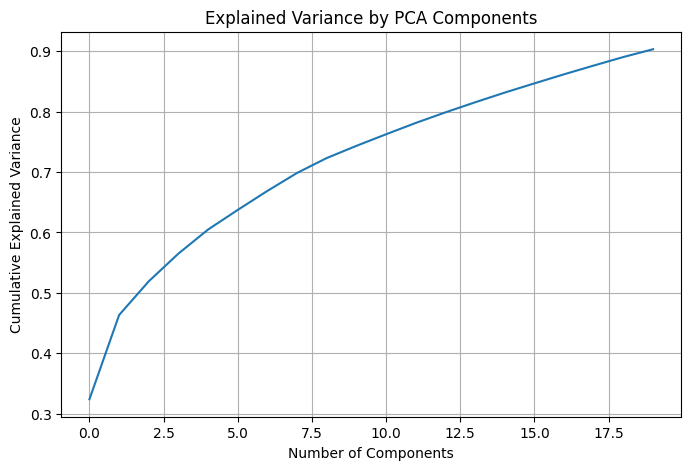

In [ ]:
# Step 1: PCA after Scaling (Before RFE)
# Reduce to 20 components for visualization or speed (you can change this)
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Explained Variance Plot
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    print(f"\n Training {name}...")
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_val_pca)

    print(f" {name} Results:")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))


 Training Logistic Regression...
 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.38      0.48      0.42       474
           1       0.55      0.21      0.31       371
           2       0.35      0.43      0.38       410

    accuracy                           0.38      1255
   macro avg       0.42      0.37      0.37      1255
weighted avg       0.42      0.38      0.38      1255

Confusion Matrix:
[[226  39 209]
 [168  79 124]
 [208  25 177]]

 Training Decision Tree...
 Decision Tree Results:
              precision    recall  f1-score   support

           0       0.39      0.39      0.39       474
           1       0.38      0.30      0.34       371
           2       0.33      0.39      0.36       410

    accuracy                           0.36      1255
   macro avg       0.37      0.36      0.36      1255
weighted avg       0.37      0.36      0.36      1255

Confusion Matrix:
[[185 105 184]
 [122 113 136]
 [172  80 

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:46:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost Results:
              precision    recall  f1-score   support

           0       0.36      0.36      0.36       474
           1       0.41      0.20      0.27       371
           2       0.31      0.45      0.37       410

    accuracy                           0.35      1255
   macro avg       0.36      0.34      0.33      1255
weighted avg       0.36      0.35      0.34      1255

Confusion Matrix:
[[171  58 245]
 [133  76 162]
 [171  53 186]]


In [ ]:
rfc_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rfc = RandomForestClassifier(random_state=42)
grid_rfc = GridSearchCV(rfc, rfc_params, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1, verbose=2)

# Fit on PCA-reduced data
grid_rfc.fit(X_train_pca, y_train)

print("\n Best Random Forest Params:", grid_rfc.best_params_)
print(f" Best CV Accuracy: {grid_rfc.best_score_:.4f}")

# Evaluate on Validation Set
y_val_pred_rfc = grid_rfc.predict(X_val_pca)
print("\n Tuned Random Forest Validation Report:")
print(classification_report(y_val, y_val_pred_rfc))


Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
 Best CV Accuracy: 0.3926

 Tuned Random Forest Validation Report:
              precision    recall  f1-score   support

           0       0.40      0.47      0.43       474
           1       0.51      0.20      0.28       371
           2       0.35      0.47      0.40       410

    accuracy                           0.39      1255
   macro avg       0.42      0.38      0.37      1255
weighted avg       0.41      0.39      0.38      1255

